# Time Series 性質與資料合成

這邊我們先給各位看一下time series的基本樣貌

課程包含以下內容:
- Time Series Data性質與合成
    - Level
    - Trend
    - Seasonality
    - Time Series性值疊加
    - Noise

#### **開始前請先安裝或import基本套件**
#### **若使用Jupyter Notebook開啟請轉成tree view方便顯示plotly出來的圖**

In [1]:
! pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from plotly import express as px

**另外我們也先準備一個畫圖的function，我們不會放重點在這邊但後面會用它來看一些time series處理的過程**

In [3]:
def plot_series(time, series, start=0, end=None, labels=None):
    
    ## Visualizes time series data
    ## Args:
    #  time (array of int) - 時間點, 長度為T
    #  series (list of array of int) - 時間點對應的資料列表，列表內時間序列數量為D，每筆資料長度為T，若非為列表則轉為列表
    #  start (int) - 開始的資料序(第幾筆)
    #  end (int) -   結束繪製的資料序(第幾筆)
    #  labels (list of strings)- 對於多時間序列或多維度的標註
    
    # 若資料只有一筆，則轉為list
    if type(series)!=list:
        series=[series]
        
    if not end:
        end=len(series[0])
    
    if labels:
    # 設立dictionary, 讓plotly畫訊號線時可以標註label    
        dictionary={"time":time}
        for idx,l in enumerate(labels):
            # 截斷資料，保留想看的部分，並分段紀錄於dictionary中
            dictionary.update({l:series[idx][start:end]})
        # 畫訊號線
        fig = px.line(dictionary,x="time",y=list(dictionary.keys())[1:],width=1000, height=400)
    else:
        # 畫訊號線
        fig = px.line(x=time,y=series,width=1000, height=400)
    fig.show()

## Time Series Data性質

時間序列資料中有些基本性質是我們預測的目標，以下我們用簡單的合成序列來說明

### Level

Level是一個資料最基本的屬性，代表這個訊號主要的大小，會用固定值來model，例如median, mean, mininum之類。

例如在房價在今年跟去年平均值不一樣，我們就可以說它們的level不同。

最簡單我們用一條自己合成的水平線來做展示

In [4]:
def level(time, bias=0.):
    # 產生合成水平直線資料，其長度與時間等長，直線的大小為輸入的level
    ##Args:
    #  time (array of int) - 時間點, 長度為T
    #  level (float) - 設定資料的level
    ##Returns:
    #  series (array of float) - 產出level 與設定相同的一條線
    
    series=np.zeros_like(time)+bias
    return series

In [5]:
# 產生time steps, 假設就365天的資料
time = np.arange(365)

# 設定不同的level的訊號要偏多少
bais = [-1,1,2,3]

# 合成訊號
series = [level(time, b) for b in bais]

# 畫出來
plot_series(time, series, 
            labels=[f'level={b}' for b in bais])

不過就numpy的性質，一個array可以直接用+號將全體內容加上一個bias，所以上述funciton後面就不用了

### Trend

Trend是序列的趨勢，代表這個序列改變的方向，例如傾斜程度大小，傾斜方向是正還負

最簡單我們用一條傾斜的直線來展示trend

In [6]:
def trend(time, slope=0):
    # 產生合成水平直線資料，其長度與時間等長，直線趨勢與設定slope相同
    ##Args:
    #  time (array of int) - 時間點, 長度為T
    #  slope (float) - 設定資料的傾斜程度與正負
    ##Returns:
    #  series (array of float) -  產出slope 與設定相同的一條線

    series = slope * time

    return series

In [7]:
# 設定time steps, 假設就365天的資料
time = np.arange(365)

# 設定不同trend的傾斜程度為多少
slopes = [-0.1, 0.1,0.2,0.3]

# 依照不同傾斜程度合成資料
series = [trend(time, s) for s in slopes]

# 畫出來
plot_series(time, series, 
            labels=[f'slope={s}' for s in slopes])

目前資料可以由公式推導知道這些slope, bias，但我們這邊先假設這是一個野生的資料，我們不知道它的function。

如此會需要一些模型來完成推導

###  Seasonality

季節性這個直譯有點特定性太強，我們姑且翻譯成序列的周期性。

有時序列會有可能在一定周期重複顯現，例如東亞梅花的開花數量在冬天會比較多，而使得年復一年，梅花開花數量這個時間序列的數值在冬天都會呈現高峰，這樣就是具周期性。而有周期性的序列，會依照周期不斷呈現一定的pattern，例如鐘形分布，三角形，或者sine, cosing等等。

我們可以拿個簡單的重複三角形來展示這個功能

In [8]:
def seasonal_pattern(season_time,pattern_type='triangle'):
    # 產生某個特定pattern，
    ##Args:
    #  season_time (array of float) - 周期內的時間點, 長度為T
    #  pattern_type (str) -  這邊提供triangle與cosine
    ##Returns:
    #  data_pattern (array of float) -  根據自訂函式產出特定的pattern

    # 用特定function生成pattern
    
    if pattern_type=='triangle':
        
        data_pattern = np.where(season_time < 0.5,
                        season_time*2,
                        2-season_time*2)
        
    if pattern_type=='cosine':
        data_pattern=np.cos(season_time*np.pi*2)
        
    return data_pattern

In [9]:
# 設定season time steps, 假設就365天的資料
time = np.arange(365)/365

# 設定不同pattern
pattern = ['triangle','cosine']

# 根據不同pattern設定合成一周期的序列
series = [seasonal_pattern(time,p) for p in pattern]

# 畫出來
plot_series(time, series,labels=pattern)

周期性序列的組成，除了有剛剛的pattern外，還會有一些更動，例如序列周期、幅度、相位會影響序列的樣貌。

這邊我們把剛剛單周期序列進行連續生成，組成好幾個週期的序列

In [10]:
def seasonality(time, period, amplitude=1, phase=30,pattern_type='triangle'):
    ## Repeats the same pattern at each period
    ## Args:
    #   time (array of int) - 時間點, 長度為T
    #   period (int) - 週期長度，必小於T
    #   amplitude (float) - 序列幅度大小
    #   phase (int) - 相位，為遞移量，正的向左(提前)、負的向右(延後)
    #   pattern_type (str) -  這邊提供triangle與cosine
    ## Returns:
    #   data_pattern (array of float) - 有指定周期、振幅、相位、pattern後的time series
    
    # 將時間依週期重置為0
    season_time = ((time + phase) % period) / period

    # 產生週期性訊號並乘上幅度
    data_pattern = amplitude * seasonal_pattern(season_time,pattern_type)

    return data_pattern

In [11]:
# 設定time steps, 假設就4年的資料
time = np.arange(4 * 365)

# 給定週期參數
periods = [180,360,720]

# 合成訊號
series = [seasonality(time, period=p,pattern_type='triangle') for p in periods]
# 畫出來
plot_series(time, series,
            labels=[f'period={p}' for p in periods])

### Time Series性質疊加

剛提到的幾種性質其實都可能同時存在一個時間序列中，我們用合成訊號來看。

In [12]:
# 設定time steps, 假設就4年的資料
time = np.arange(4 * 365)

# 定義各種性質
bias=500
slope = 0.1
period = 180
amplitude = 40
# 合成資料
series =  level(time,bias) \
         +trend(time, slope) \
         +seasonality(time, period=period, amplitude=amplitude,pattern_type='triangle')
# 畫
plot_series(time, series)

可以看到它的最低值至少大於500，長期斜率約為0.1，波動周期為180天，並且周期幅度為40，周期pattern是三角形。

是上述很多性值的疊加狀態。

### Noise

物理世界的訊號通常帶有雜訊，我們來看加入雜訊後長什麼樣子

In [13]:
def noise(time, noise_level=1, seed=None):
    ## 合成雜訊，這邊用高斯雜訊，機率密度為常態分布
    ## Args:
    #   time (array of int) - 時間點, 長度為T
    #   noise_level (float) - 雜訊大小
    #   seed (int) - 同樣的seed可以重現同樣的雜訊
    ## Returns:
    #   noise (array of float) - 雜訊時間序列


    # 做一個基於某個seed的雜訊生成器
    rnd = np.random.RandomState(seed)
    
    # 生與time同長度的雜訊，並且乘上雜訊大小 (不乘的話，標準差是1)
    noise = rnd.randn(len(time)) * noise_level
    
    return noise


In [14]:
# 給一個4年的time steps
time = np.arange(4 * 365)
# 設noise 強度
noise_levels=[2.,1.]
# 合成雜訊
series = [noise(time, noise_level=nl,seed=2022) for nl in noise_levels]
# 畫
plot_series(time,
            series=series,
            labels=[f'noise_levels={nl}' for nl in noise_levels])

來看看跟剛剛的一些性質疊起來長什麼樣子

In [15]:
# 設定time steps, 假設就4年的資料
time = np.arange(4 * 365)

# 定義各種性質
bias=500
slope = 0.1
period = 180
amplitude = 40
# 設noise 強度
noise_level=5.

# 合成資料
signal_series =  level(time,bias) \
         +trend(time, slope) \
         +seasonality(time, period=period, amplitude=amplitude,pattern_type='triangle')
noise_series = noise(time, noise_level=noise_level) 

series=signal_series+noise_series

# 畫
plot_series(time, [series,signal_series],labels=['noisy','noise free'])

剛剛的時間序列會出現有不規則的毛邊，這些毛邊沒有規則，並且還是看得出來前面序列的周期性、大小、趨勢等等。

我們現在設定的noise大小還沒有很大，所以加上去沒有多很大毛邊，可自行加大noise_level，試試看加到多少會使得根本認不出原本資料?

In [16]:
noise_series = noise(time, noise_level=15) 
series=signal_series+noise_series
plot_series(time, [series,signal_series],labels=['noisy','noise free'])

我們可以把前述幾個function可以打包在一起，做一個data generator

In [17]:
def trend(time, slope=0):
    # 產生合成水平直線資料，其長度與時間等長，直線趨勢與設定slope相同
    ##Args:
    #  time (array of int) - 時間點, 長度為T
    #  slope (float) - 設定資料的傾斜程度與正負
    ##Returns:
    #  series (array of float) -  產出slope 與設定相同的一條線

    series = slope * time

    return series
def seasonal_pattern(season_time,pattern_type='triangle'):
    # 產生某個特定pattern，
    ##Args:
    #  season_time (array of float) - 周期內的時間點, 長度為T
    #  pattern_type (str) -  這邊提供triangle與cosine
    ##Returns:
    #  data_pattern (array of float) -  根據自訂函式產出特定的pattern

    # 用特定function生成pattern
    
    if pattern_type=='triangle':
        
        data_pattern = np.where(season_time < 0.5,
                        season_time*2,
                        2-season_time*2)
        
    if pattern_type=='cosine':
        data_pattern=np.cos(season_time*np.pi*2)
        
    return data_pattern
def seasonality(time, period, amplitude=1, phase=30,pattern_type='triangle'):
    ## Repeats the same pattern at each period
    ## Args:
    #   time (array of int) - 時間點, 長度為T
    #   period (int) - 週期長度，必小於T
    #   amplitude (float) - 序列幅度大小
    #   phase (int) - 相位，為遞移量，正的向左(提前)、負的向右(延後)
    #   pattern_type (str) -  這邊提供triangle與cosine
    ## Returns:
    #   data_pattern (array of float) - 有指定周期、振幅、相位、pattern後的time series
    
    # 將時間依週期重置為0
    season_time = ((time + phase) % period) / period

    # 產生週期性訊號並乘上幅度
    data_pattern = amplitude * seasonal_pattern(season_time,pattern_type)

    return data_pattern
def noise(time, noise_level=1, seed=None):
    ## 合成雜訊，這邊用高斯雜訊，機率密度為常態分布
    ## Args:
    #   time (array of int) - 時間點, 長度為T
    #   noise_level (float) - 雜訊大小
    #   seed (int) - 同樣的seed可以重現同樣的雜訊
    ## Returns:
    #   noise (array of float) - 雜訊時間序列


    # 做一個基於某個seed的雜訊生成器
    rnd = np.random.RandomState(seed)
    
    # 生與time同長度的雜訊，並且乘上雜訊大小 (不乘的話，標準差是1)
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

def toy_generation(time=np.arange(4 * 365),
            bias=500.,
            slope = 0.1,
            period = 180,
            amplitude = 40.,
            phase= 30,
            pattern_type = 'triangle',
            noise_level=5.,
            seed=2022):
    signal_series =  bias \
                     +trend(time, slope) \
                     +seasonality(time,phase, period,amplitude,pattern_type)
    noise_series = noise(time,noise_level,seed) 

    series=signal_series+noise_series
    return series

In [18]:
# 生成時可快速調整想要的參數

series=toy_generation(time=np.arange(4 * 365),
                        bias=500.,
                        slope = 0.1,
                        period = 180,
                        amplitude = 40.,
                        phase= 30,
                        pattern_type = 'triangle',
                        noise_level=5.,
                        seed=2022)

## Examples for Other Trends and Seasonality

In [61]:
time=np.arange(100)
no_trend=np.zeros_like(time)
additive_trend=time*0.3
multiplicative_trend=time**2*0.01
polynomial_trend=-time**3*0.0005+time**2*0.05+time*0.1

In [62]:
plot_series(time, [no_trend,
                   additive_trend,
                   multiplicative_trend,
                   polynomial_trend],
            labels=['no_trend',
                    'additive_trend',
                    'multiplicative_trend',
                    'polynomial_trend'
                    ])

In [50]:
no_seasonality=np.zeros_like(time)
additive_seasonality=seasonality(time,phase=0, period=30,amplitude=40.,pattern_type='cosine')
multiplicative_seasonality=time*additive_seasonality*0.02

In [51]:
plot_series(time, [no_seasonality,
                   additive_seasonality,
                   multiplicative_seasonality],
            labels=['no_seasonality',
                    'additive_seasonality',
                    'multiplicative_seasonality'
                    ])

(-150.0, 150.0)

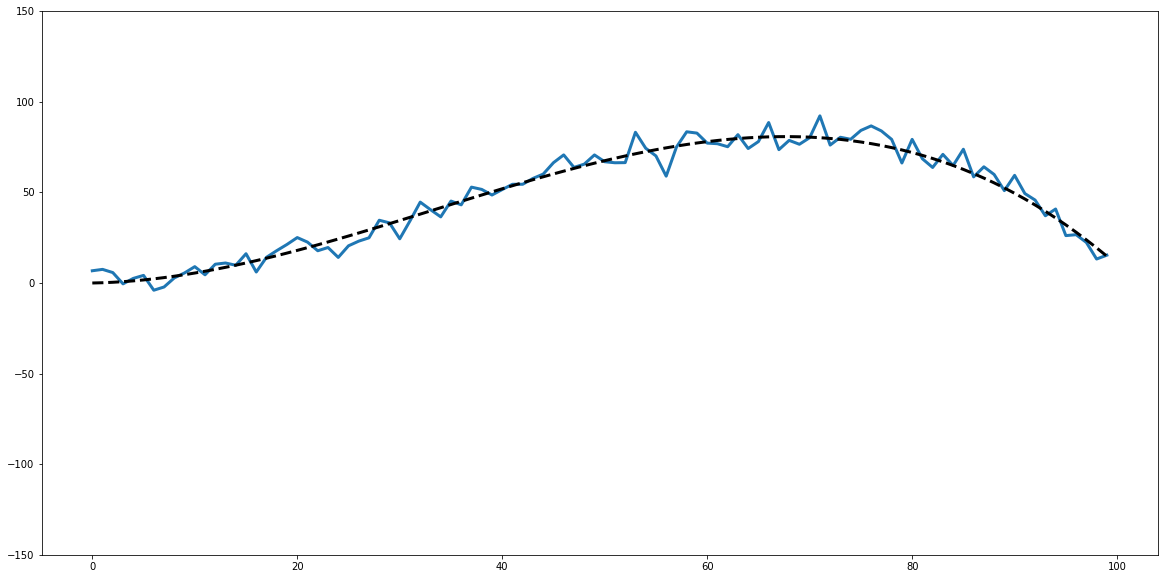

In [73]:
%matplotlib inline
plt.figure(figsize=[20,10])
noise_series = noise(time, noise_level=5) 
plt.plot(time,polynomial_trend+no_seasonality+noise_series,'-',label='W=1',linewidth=3)
plt.plot(time,polynomial_trend,'k--',label='W=3',linewidth=3)
# plt.legend(fontsize='large')
plt.ylim([-150,150])